<a href="https://colab.research.google.com/github/Imartinezcuevas/k_brazos_MC_OL/blob/main/bandit_experiment_ucb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos de UCB en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos de Ascenso del gradiente en un problema de k-armed bandit.

    Author: Iván Martínez Cuevas y Antonio Orenes Lucas
    Email: ivan.martinezc@um.es y antonio.orenesl@um.es
    Date: 2025/02/12

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html

# Introducción
En este experimento, nos centraremos en dos algoritmos populares para resolver el problema del bandido de k-brazos: UCB1 y UCB2. Ambos pertenecen a la familia de algoritmos Upper Confidence Bound (UCB), que utilizan límites de confianza superiores para guiar la toma de decisiones. UCB1 es un algoritmo simple y efectivo que ha demostrado un rendimiento sólido. UCB2, por otro lado, introduce un parámetro α que permite un control más fino del equilibrio entre exploración y explotación.

Nuestro objetivo principal es comparar el rendimiento de UCB1 y UCB2 en diferentes escenarios. Para ello, realizaremos una serie de experimentos variando parámetros clave como el número de brazos (k), la distribución de recompensas y, en el caso de UCB2, el parámetro α. Mediremos y compararemos el arrepentimiento acumulado, el porcentaje de selecciones óptimas y las recompensas promedio obtenidas por cada algoritmo

## Preparación del entorno

In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/Imartinezcuevas/k_brazos_MC_OL.git
!cd k_brazos_MC_OL/

Cloning into 'k_brazos_MC_OL'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 212 (delta 112), reused 127 (delta 51), pack-reused 0 (from 0)
Receiving objects: 100% (212/212), 12.67 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_MC_OL/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, UCB1, UCB2
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_MC_OL/src']


## Bucle experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    # Para almacenar selecciones y recompensas promedio de cada brazo por algoritmo
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Número de selecciones por brazo
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Suma de recompensas por brazo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)
        # Obtener la recompensa esperada óptima.
        optimal_reward = current_bandit.get_expected_value(optimal_arm)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.
                regrets[idx, step] = optimal_reward*(step+1) - total_rewards_per_algo[idx] # Acumular el regret en la matriz regrets para el algoritmo idx en el paso step.

                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm",
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Registrar número de selecciones y recompensas por brazo
                arm_counts[idx, chosen_arm] += 1
                arm_rewards[idx, chosen_arm] += reward


    rewards /= runs
    regrets /= runs  # Calcular el promedio del regret acumulado
    arm_avg_rewards = np.divide(arm_rewards, arm_counts, out=np.zeros_like(arm_rewards), where=arm_counts != 0)
    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    return rewards, optimal_selections, regrets, arm_counts, arm_avg_rewards

# Análisis individual
El objetivo de este estudio es aislar y analizar la influencia de los parámetros en el rendimiento de los algoritmos. Para lograr esto, hemos decidido fijar otros parámetros relevantes del experimento, asegurando así que las variaciones en los resultados se deban exclusivamente a los cambios en los parámetros.

Pero como sabemos UCB1 no tiene parámetros, por lo que probaremos los dos algoritmos al mismo tiempo. Variando alpha en UCB2 para ver con cual obtenemos mejores resultado.

* **Parámetros Fijos**

  * Número de brazos (k): Se establecerá en 10.
  * Distribución de recompensas: Se utilizará una distribución normal. Despues utilizaremos las distribuciones binomial y de Bernoulli.
  * Número de pasos (steps): Cada ejecución del algoritmo constará de 1000 pasos.
  * Número de ejecuciones (runs): Se realizarán 500 ejecuciones independientes del experimento.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=0.7), UCB2(k=k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Recompensa promedio

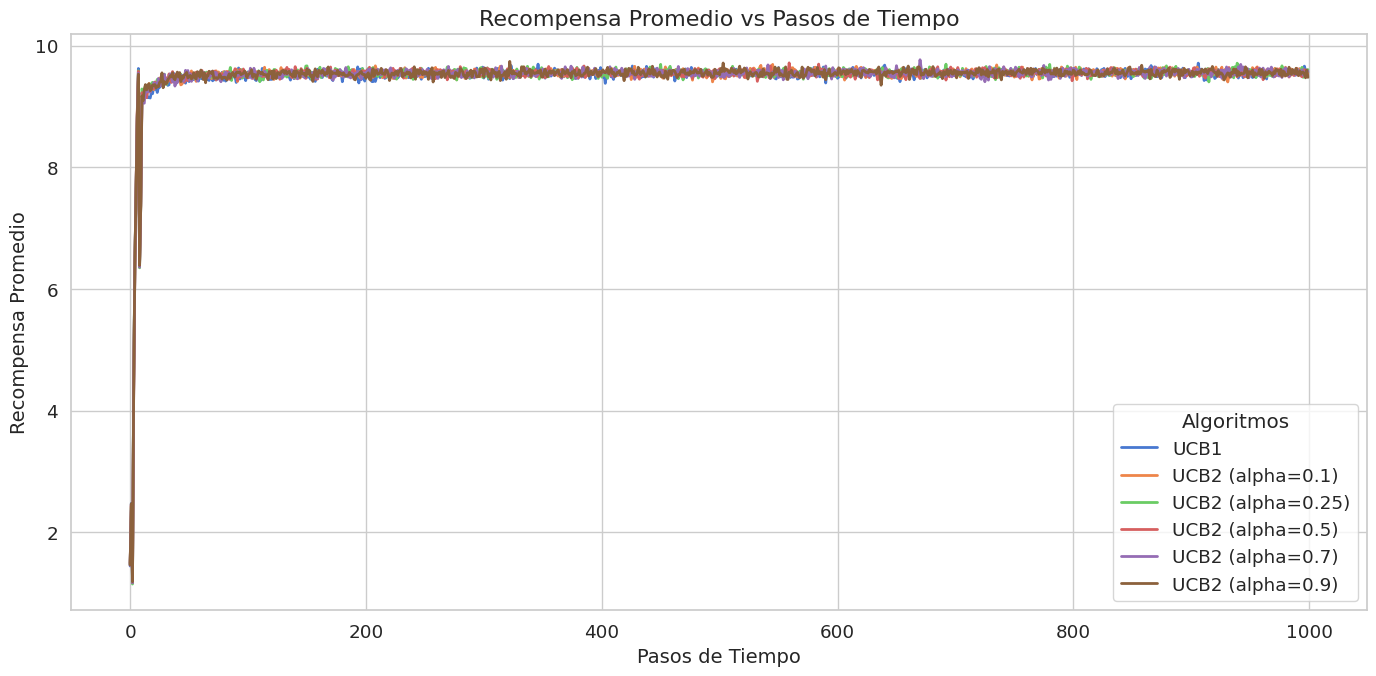

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  *  Todas las variantes de UCB2 (α = 0.1, 0.25, 0.5, 0.7, 0.9) y UCB1 convergen rápidamente a una recompensa promedio cercana a 10.
  * En las primeras iteraciones hay una fase de exploración en la que la recompensa fluctúa, pero después se estabiliza.
  
**Conclusiones**
  * UCB1 y todas las variantes de UCB2 tienen un desempeño similar, logrando rápidamente una recompensa óptima.
  * El aprendizaje es rápido, con las curvas estabilizándose en muy pocos pasos de tiempo.

### Regret acumulado

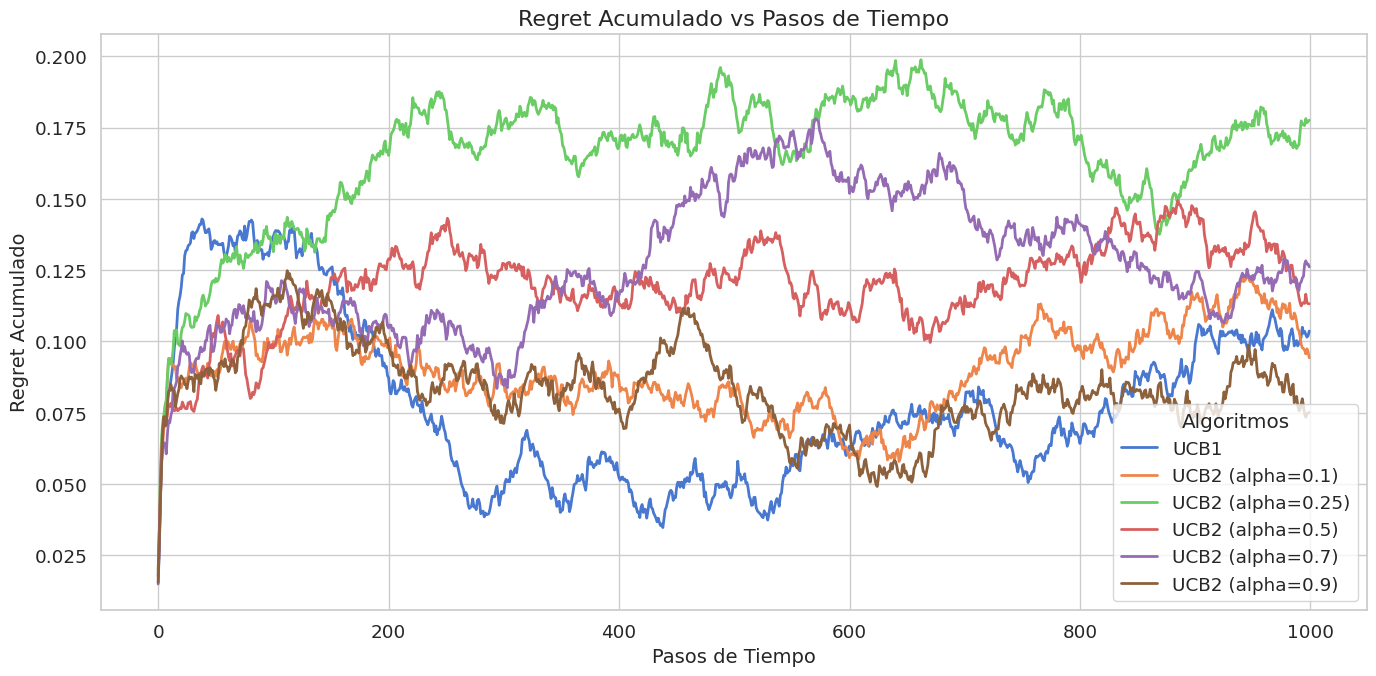

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", que evalúa el desempeño de diferentes algoritmos en términos de la pérdida acumulada al no elegir siempre la mejor acción.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  * En general, el regret acumulado es muy pequeño, lo que confirma que los algoritmos aprenden rápido y alcanzan el óptimo en pocas iteraciones.
  * Este resultado es consistente con la imagen anterior, donde las recompensas promedio alcanzaban valores cercanos a 10 rápidamente.
  * Las variaciones en regret pueden deberse principalmente a la varianza inherente en la distribución de recompensas, más que a diferencias fundamentales en los algoritmos.

**Conclusiones**
  * El aprendizaje es rápido y eficiente, ya que el regret acumulado es bajo en todos los casos.
  * No hay diferencias significativas entre las variantes de UCB2 que justifiquen una preferencia clara por un valor de α sobre otro.
  * Las fluctuaciones pueden deberse a la varianza de la distribución, más que a diferencias en el rendimiento real de los algoritmos.

### Porcentaje de selección del brazo óptimo

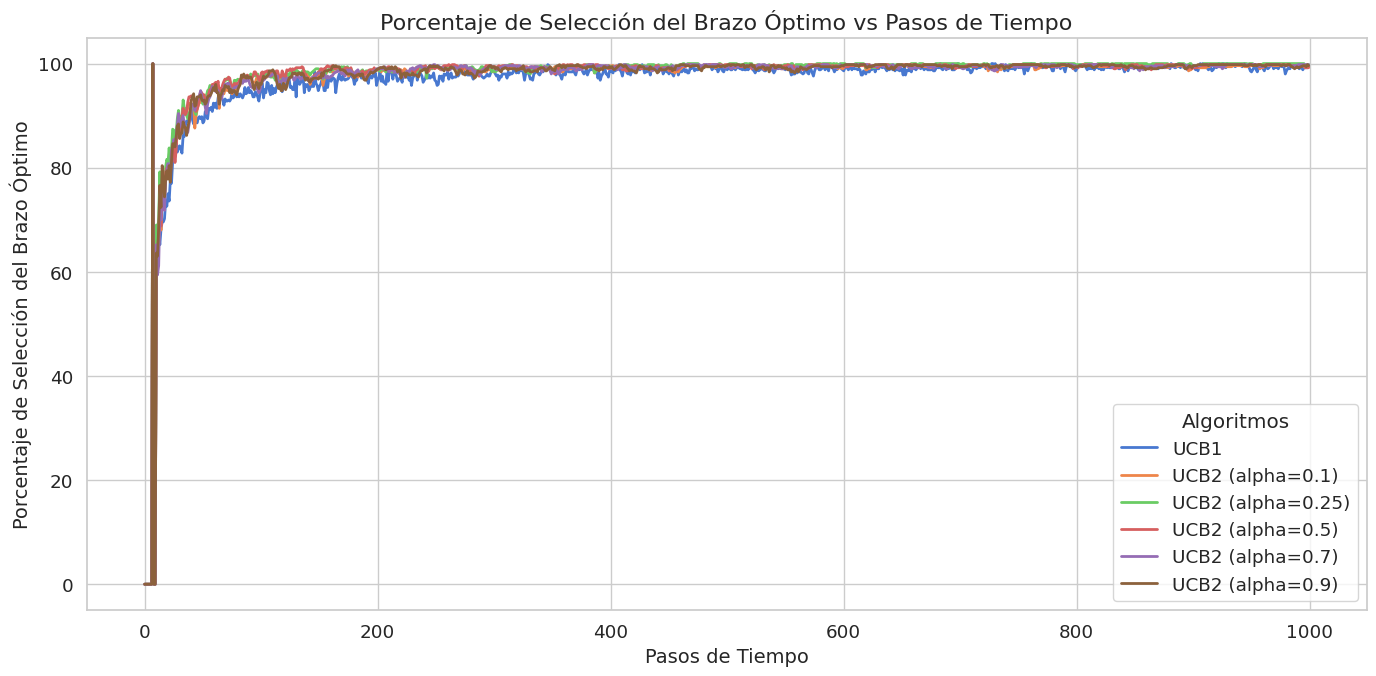

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Observaciones principales**
  * Todas las variantes de UCB2 (α = 0.1, 0.25, 0.5, 0.7, 0.9) y UCB1 convergen rápidamente a una porcentaje de selección del brazo óptimo del 100%.
  * En las primeras iteraciones hay una fase de exploración en la que la recompensa fluctúa, pero después se estabiliza.
  * Se puede ver UCB1, sobre todo las iteraciones inicales, que tiene un desempeño ligeramente peor.

**Conclusiones**
* Parece que UCB2 es la mejor estrategia para seleccionar consistentemente el brazo óptimo.

### Conclusión
Los resultados obtenidos para los algoritmos UCB1 y UCB2 muestran un desempeño notablemente eficiente y rápido, alcanzando una recompensa óptima cercana al valor máximo en muy pocos pasos de tiempo. Tanto UCB1 como las diferentes variantes de UCB2 (con valores de α entre 0.1 y 0.9) convergen rápidamente, lo que refleja la habilidad del algoritmo para equilibrar la exploración y la explotación de manera eficiente.

Una posible razón por la cual los algoritmos UCB funcionan tan bien en este contexto es la propiedad inherente del Upper Confidence Bound: cada acción tiene una "barrera de confianza" que ajusta el balance entre explorar nuevos brazos y explotar los ya conocidos. Este mecanismo permite que, al principio, el algoritmo explore diferentes brazos de forma adecuada, pero luego se estabilice rápidamente cuando se encuentra el brazo óptimo.

La distribución normal de recompensas también juega un papel positivo en el desempeño de estos algoritmos. La distribución normal es relativamente predecible y no tiene la variabilidad excesiva de distribuciones como binomial o Bernoulli. Esto facilita la convergencia a una solución óptima, ya que las recompensas de los brazos no son excesivamente ruidosas o impredecibles. Dado que UCB se basa en el cálculo de las confianzas asociadas a las recompensas esperadas, las distribuciones normales permiten que esas estimaciones se realicen de manera más precisa y estable, lo que acelera el proceso de aprendizaje.

# Análisis comparativo

## Comparación entre número de brazos
Como hemos observado que todas las pruebas obtienen unos resultados muy similares. Vamos a estudiar los algoritmos en diferentes niveles de complejidad. Para ello en este apartado se estudiará como el número de brazos afecta en la capacidad de convergencia y la eficiencia de ambos algoritmos.

Los objetivos son:
* Determinar como el rendimiento de los algoritmos se ve afectado al aumentar el número de brazos.
* Observar como la velocidad de convergencia varía en función del número de brazos.

Se realizarán experimentos variando el número de brazos en el siguiente rango $[15, 30]$.

#### K = 15

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 15  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=0.7), UCB2(k=k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 15 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

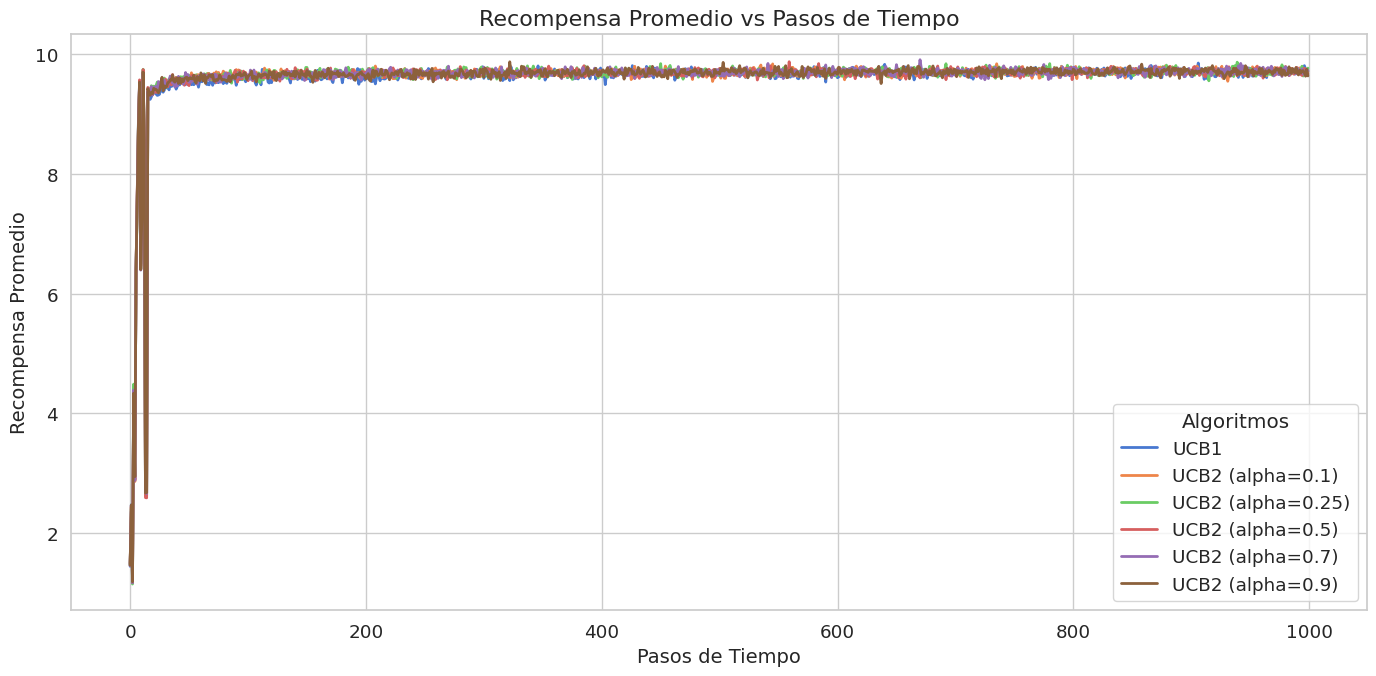

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

El aumento a 15 brazos no generó diferencias significativas en el desempeño de UCB1 y UCB2. Todos los algoritmos convergen a una recompensa alta y estable.

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  *  En los primeros pasos, las recompensas varían significativamente, lo cual es esperable debido a la fase de exploración inicial.
  * Las curvas de los distintos algoritmos son prácticamente indistinguibles, lo que sugiere que, a pesar del aumento en la cantidad de brazos, tanto UCB1 como UCB2 (con distintos valores de α) convergen a desempeños similares.

  
**Conclusiones**
  * A diferencia del caso con menos brazos, donde la exploración era más eficiente, ahora los algoritmos deben probar más opciones antes de converger a una buena política.


##### Regret acumulado

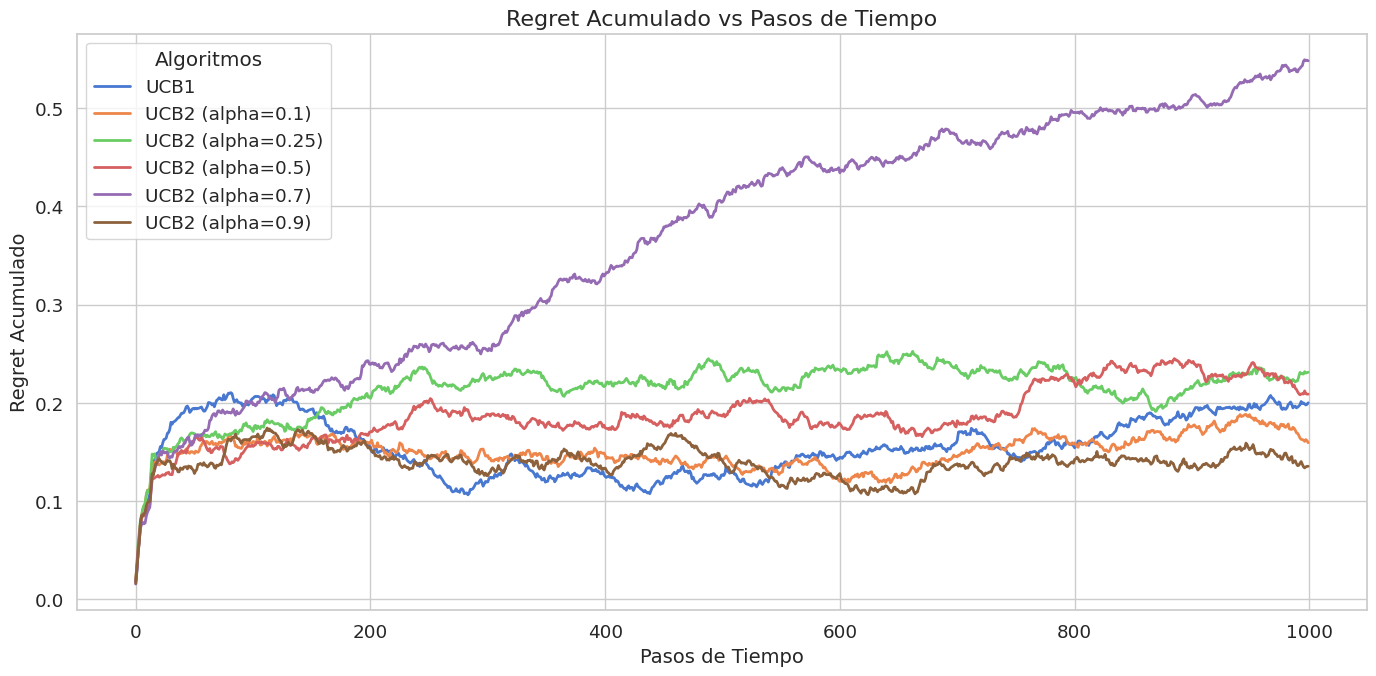

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", que evalúa el desempeño de diferentes algoritmos en términos de la pérdida acumulada al no elegir siempre la mejor acción.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  * El regret acumulado general ha aumentado, lo que era esperable, ya que al haber más brazos hay una mayor exploración inicial y más posibilidades de seleccionar opciones subóptimas.
  * El crecimiento del regret se mantiene relativamente bajo para la mayoría de los algoritmos, salvo por una excepción notable (UCB2 con α = 0.7).
  * UCB1 (azul) y UCB2 con α = 0.1 y 0.9 parecen tener el menor regret acumulado, lo que sugiere que estas configuraciones siguen siendo las más eficientes.

**Conclusiones**
  *  El aumento de brazos ha incrementado el regret acumulado, como era de esperarse.
  * UCB2 con α = 0.7 muestra un comportamiento anómalo, con un regret que sigue creciendo incluso cuando la selección del brazo óptimo es similar a las otras variantes.

##### Porcentaje de selección del brazo óptimo

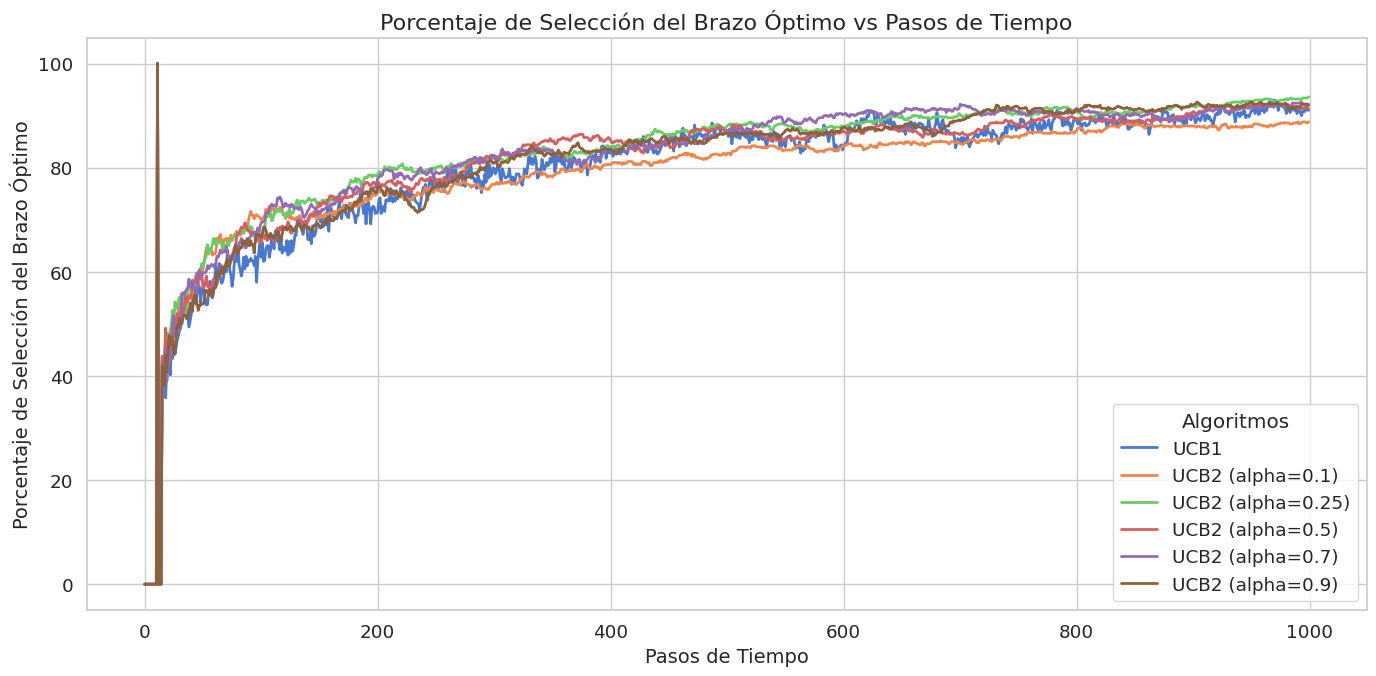

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Observaciones principales**
  * El Porcentaje de Selección del Brazo Óptimo ha bajado, lo que era esperable, ya que al haber más brazos hay una mayor exploración inicial y más posibilidades de seleccionar opciones subóptimas.
  * En las primeras iteraciones hay una fase de exploración en la que la recompensa fluctúa, pero después se estabiliza.
  * Se puede ver UCB1, sobre todo las iteraciones inicales, que tiene un desempeño ligeramente peor.
  * En general, todos estan sobre un 80% de selección del brazo óptimo.

**Conclusiones**
* Parece que UCB2 es la mejor estrategia para seleccionar consistentemente el brazo óptimo.

#### K = 20

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 20  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=0.7), UCB2(k=k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 20 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

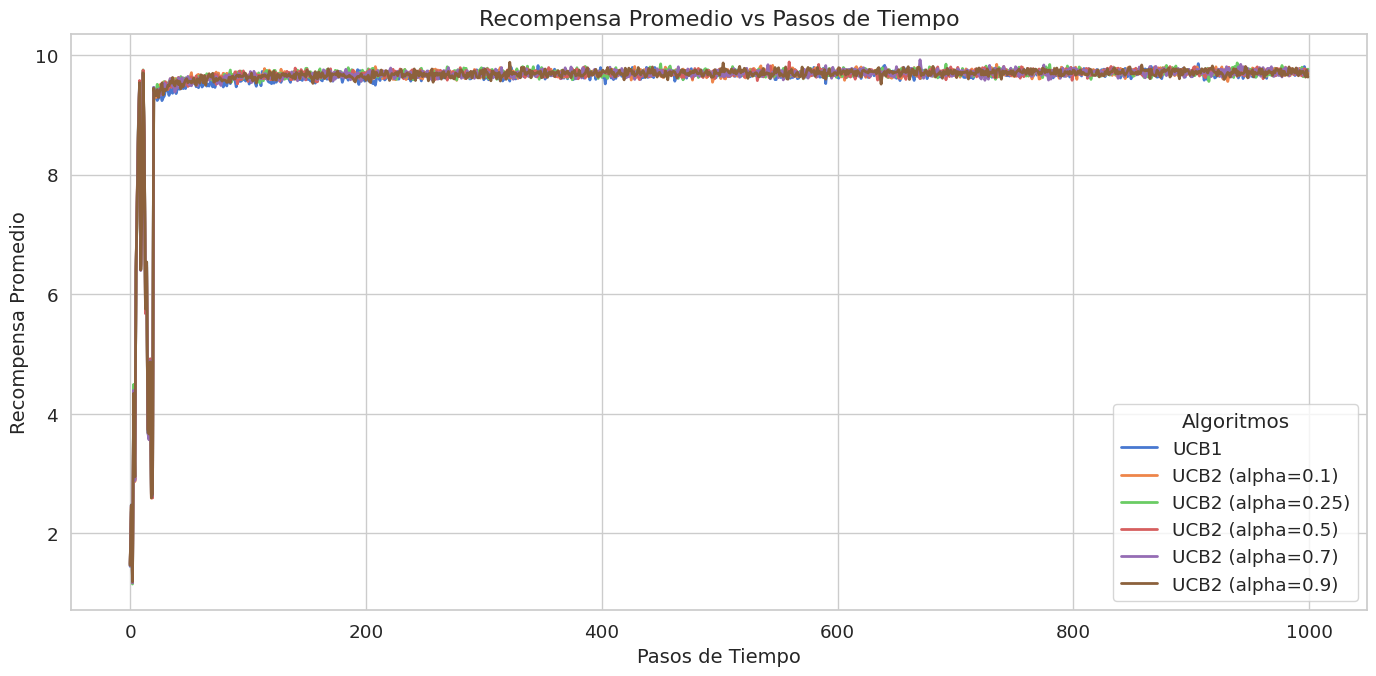

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

El aumento a 20 brazos no generó diferencias significativas en el desempeño de UCB1 y UCB2. Todos los algoritmos convergen a una recompensa alta y estable.

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  *  Como aumentamos el número de brazos, a probabilidad de que existan brazos con recompensas similares también aumenta (brazo 9 y 12). Esto puede dificultar la identificación del brazo óptimo y requerir más pasos de tiempo para que el algoritmo pueda distinguirlo claramente.
  * Con 20 brazos, el algoritmo necesita explorar un espacio mucho más grande. Esto hace que la convergencia sea más lenta, especialmente en las etapas iniciales del aprendizaje.

  
**Conclusiones**
  * A diferencia del caso con menos brazos, donde la exploración era más eficiente, ahora los algoritmos deben probar más opciones antes de converger a una buena política.


##### Regret acumulado

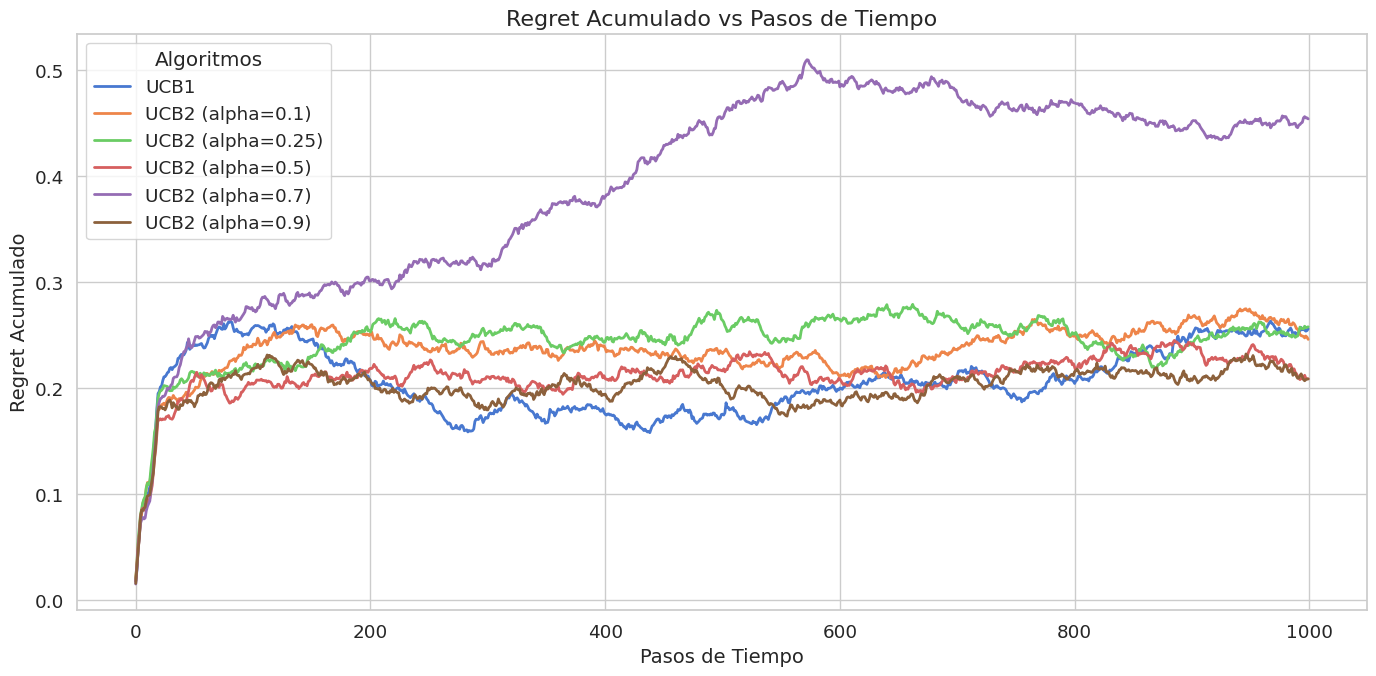

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", donde se compara el desempeño de los algoritmos UCB1 y UCB2.

**Alphas bajos**
  * Podemos observar como han cambiado las instancias que tenian menor regret acumulado. Hasta ahora el experimento con α = 1 era el que obtenia mejor regret. Sin embargo, ahora vemos como a partir de la iteracion 4 eso cambia. Con α 2 y 0.1 obtienen mejores resultados.

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", que evalúa el desempeño de diferentes algoritmos en términos de la pérdida acumulada al no elegir siempre la mejor acción.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  * El regret acumulado general ha aumentado, lo que era esperable, ya que al haber más brazos hay una mayor exploración inicial y más posibilidades de seleccionar opciones subóptimas.
  * El regret no ha aumentado tanto como de 10 a 15 brazos.
  * El crecimiento del regret se mantiene relativamente bajo para la mayoría de los algoritmos, salvo por una excepción notable (UCB2 con α = 0.7).

**Conclusiones**
  *  El aumento de brazos ha incrementado el regret acumulado, como era de esperarse.
  

##### Porcentaje de selección del brazo óptimo

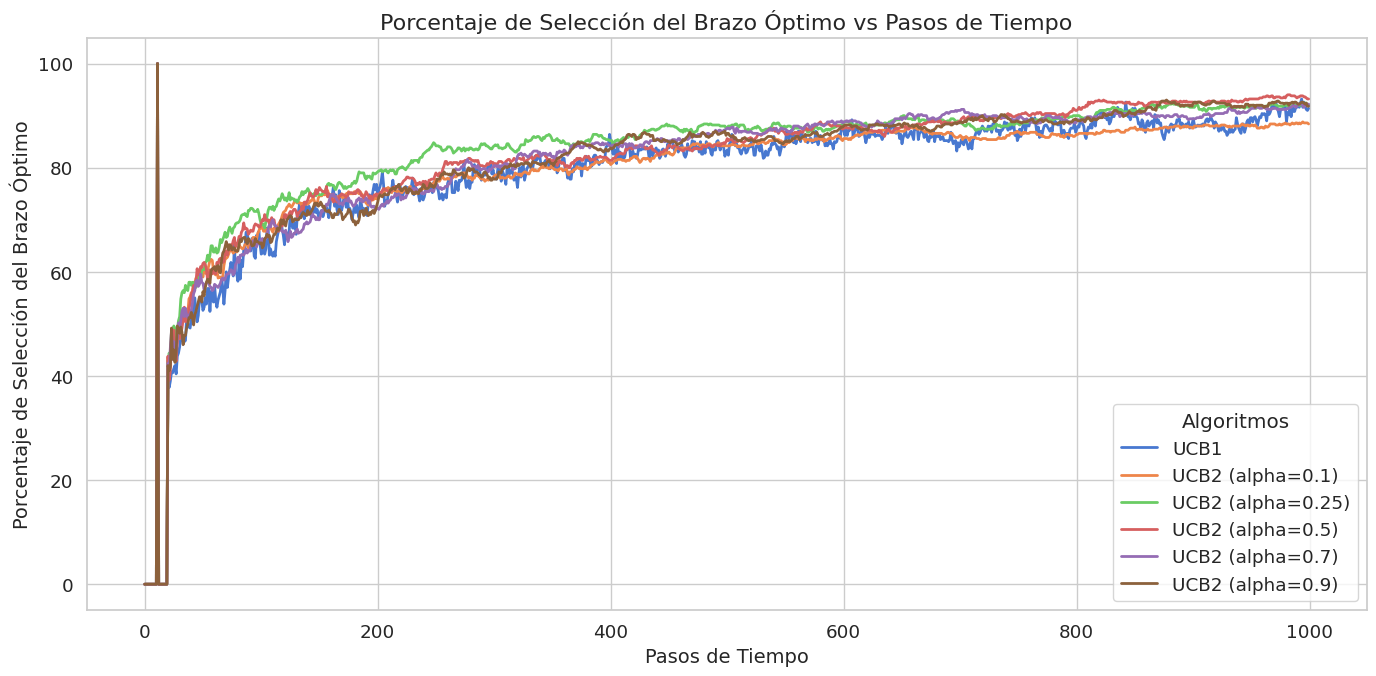

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Observaciones principales**
  * Todas las variantes de UCB2 (α = 0.1, 0.25, 0.5, 0.7, 0.9) y UCB1 convergen rápidamente a una porcentaje de selección del brazo óptimo del 95%.
  * En las primeras iteraciones hay una fase de exploración en la que la recompensa fluctúa, pero después se estabiliza.
  * Se puede ver UCB1, sobre todo las iteraciones inicales, que tiene un desempeño ligeramente peor.
  * Vemos un resultado muy similar al obtenido para 15 brazos. El rendimiento no ha empeorado.

**Conclusiones**
* Parece que UCB2 es la mejor estrategia para seleccionar consistentemente el brazo óptimo.

#### K = 30

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 30  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=0.7), UCB2(k=k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 30 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=2.91, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0), ArmNormal(mu=9.73, sigma=1.0), ArmNormal(mu=8.49, sigma=1.0), ArmNormal(mu=5.72, sigma=1.0), ArmNormal(mu=6.51, sigma=1.0), ArmNormal(mu=3.74, sigma=1.0), ArmNormal(mu=2.26, sigma=1.0), ArmNormal(mu=5.1, sigma=1.0), ArmNormal(mu=6.33, sigma=1.0), ArmNormal(mu=8.07, sigma=1.0), ArmNormal(mu=2.8, sigma=1.0), ArmNormal(mu=3.62, sigma=1.0), ArmNormal(mu=3.63, sigma=1.0), ArmNormal(mu=4.89, sigma=1.0), ArmNormal(mu=4.3, sigma=1.0), ArmNormal(mu=5.63, sigma=1.0), ArmNormal(mu=6.47, sigma=1.0), ArmNormal(mu=2.64, sigma=1.0), ArmNormal(mu=2.65, sigma=1.0), ArmNormal(mu=1.42, sigma=1.0)
Optimal arm: 12 with expected reward=9.73


##### Recompensa promedio

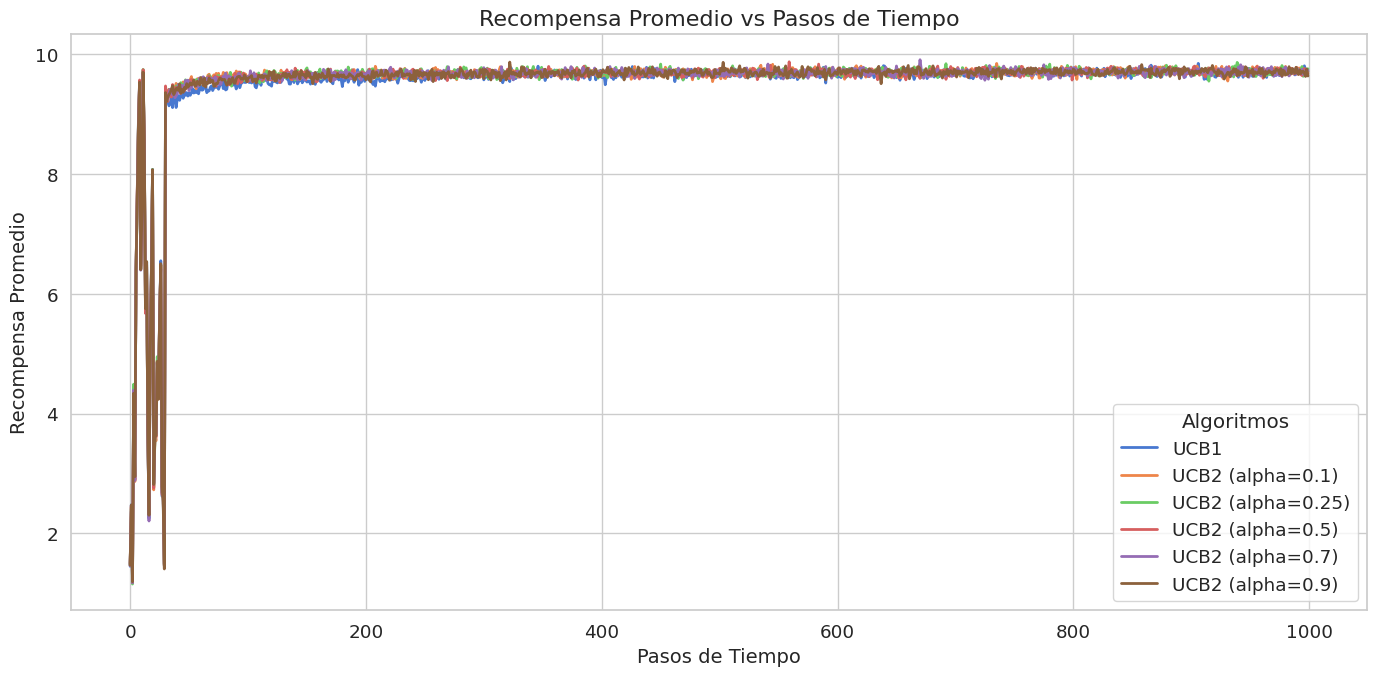

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  *  En los primeros pasos, las recompensas varían significativamente, lo cual es esperable debido a la fase de exploración inicial.
  * Las curvas de los distintos algoritmos son prácticamente indistinguibles, lo que sugiere que, a pesar del aumento en la cantidad de brazos, tanto UCB1 como UCB2 (con distintos valores de α) convergen a desempeños similares.

  
**Conclusiones**
  * A diferencia del caso con menos brazos, donde la exploración era más eficiente, ahora los algoritmos deben probar más opciones antes de converger a una buena política.
  * Salvo la fase inicial, que se vuelve más larga con cada aumento, siempre se llega a una buena política.

  

##### Regret acumulado

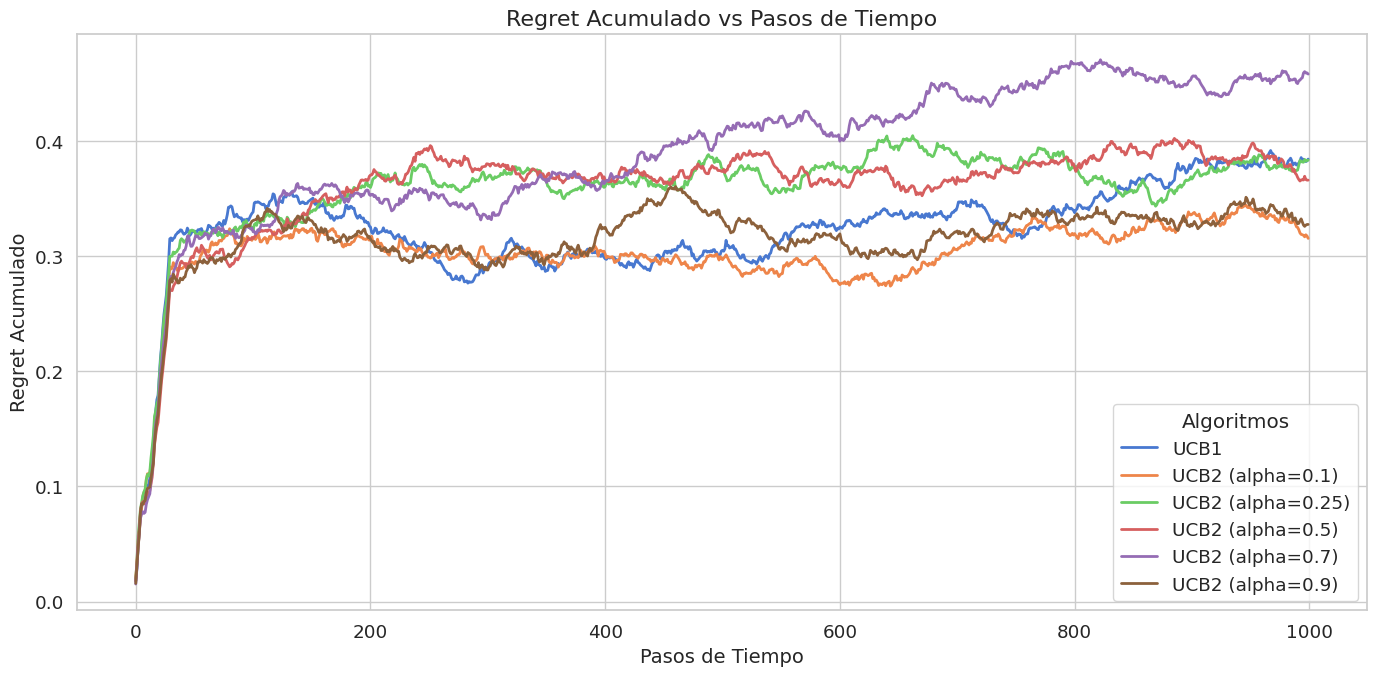

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", que evalúa el desempeño de diferentes algoritmos en términos de la pérdida acumulada al no elegir siempre la mejor acción.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  * El regret acumulado general ha aumentado, lo que era esperable, ya que al haber más brazos hay una mayor exploración inicial y más posibilidades de seleccionar opciones subóptimas.
  * Aquí si que podemos ver como el regret aumenta más debido al mayor numero de brazos. Un 0.1 más que con 20 brazos..
  * Pero una vez encuentra el brazo optimo el regret se mantiene practicamente estable.

**Conclusiones**
  *  El aumento de brazos ha incrementado el regret acumulado, como era de esperarse.
  * Volvemos a ver la variante con alpha = 0.7 con resultados más parecidos a los de las demás variantes.
  

##### Porcentaje de selección del brazo óptimo

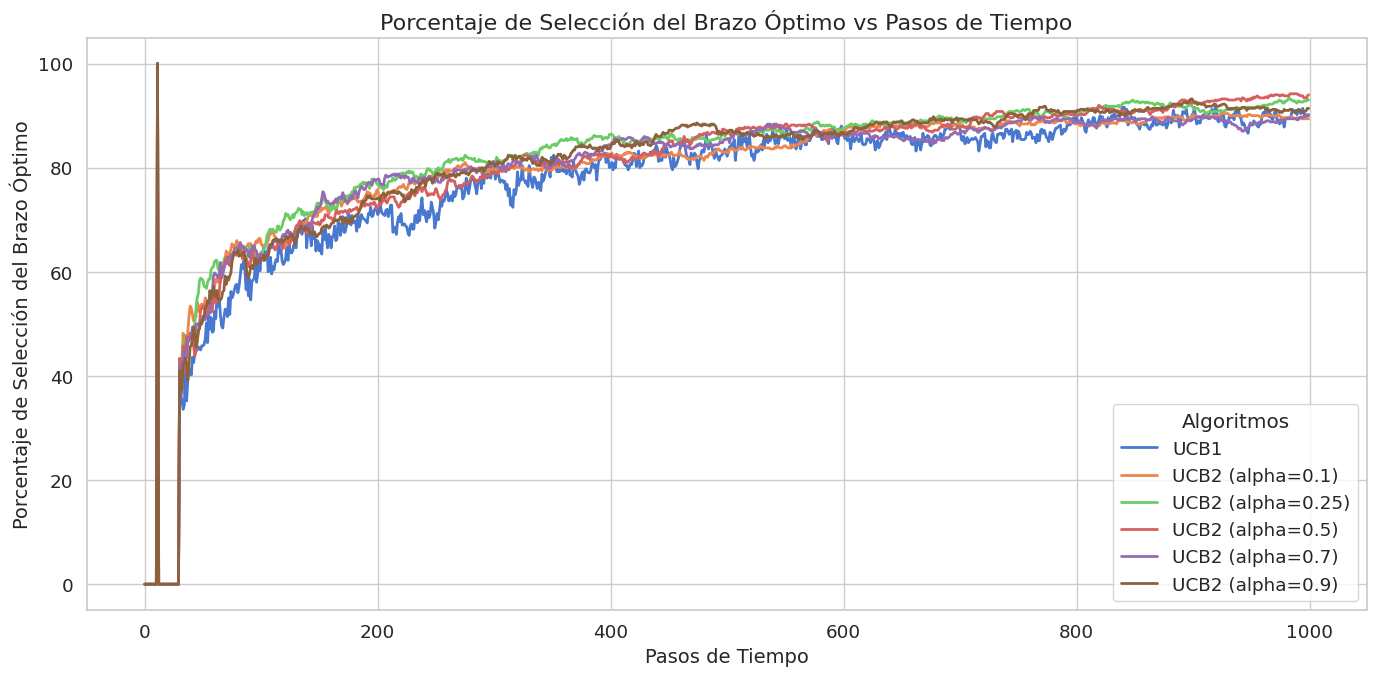

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Observaciones principales**
  * Sorprendentemente el resultado no empeora, salvo en el primer salto, donde vimos disminuir el porcentaje del 100% al 90%. Se ha mantenido ahí para los demás incrementos.
  * UCB1 sigue manteniendo el menor porcentaje de seleccion del brazo óptimo.

**Conclusiones**

* Parece que UCB2 es la mejor estrategia para seleccionar consistentemente el brazo óptimo.
* También parece que los algoritmos escalan bastante bien.

## Conclusión

El aumento en el número de brazos, de 10 a 20 y 30, ha introducido ciertas variaciones en el comportamiento de los algoritmos UCB1 y UCB2, aunque las diferencias en el rendimiento general siguen siendo relativamente pequeñas.

A medida que el número de brazos aumenta, también lo hace la probabilidad de que existan brazos con recompensas similares. Este fenómeno, observado en los gráficos de recompensa promedio, implica que, con 20 o 30 brazos, el algoritmo debe explorar más opciones antes de identificar el brazo óptimo. Este proceso de exploración adicional, reflejado en el aumento de la fase de exploración (más larga en el inicio del aprendizaje), ralentiza la convergencia del algoritmo en comparación con el caso con menos brazos.

En términos de regret acumulado, el aumento en el número de brazos también genera un incremento en la exploración inicial y, como resultado, un mayor regret en las primeras iteraciones. Este incremento es más pronunciado al aumentar de 10 a 20 brazos, pero el regret acumulado se mantiene relativamente bajo para la mayoría de los algoritmos, excepto en algunos casos con α=0.7, que presenta un desempeño más fluctuante.

## Comparación entre distribuciones
El paso final es analizar su comportamiento ante diferentes distribuciones de recompensa.

No se va a analizar la distribución normal ya que saldrían las mismas graficas que obtenidas en el apartado "Comparación entre algoritmos".

#### Distribución binomial

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k, 10)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=0.7), UCB2(k=k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=10, p=0.4), ArmBinomial(n=10, p=0.86), ArmBinomial(n=10, p=0.22), ArmBinomial(n=10, p=0.69), ArmBinomial(n=10, p=0.58), ArmBinomial(n=10, p=0.15), ArmBinomial(n=10, p=0.79), ArmBinomial(n=10, p=0.67), ArmBinomial(n=10, p=0.12), ArmBinomial(n=10, p=0.88)
Optimal arm: 10 with expected reward=8.8


##### Recompensa promedio

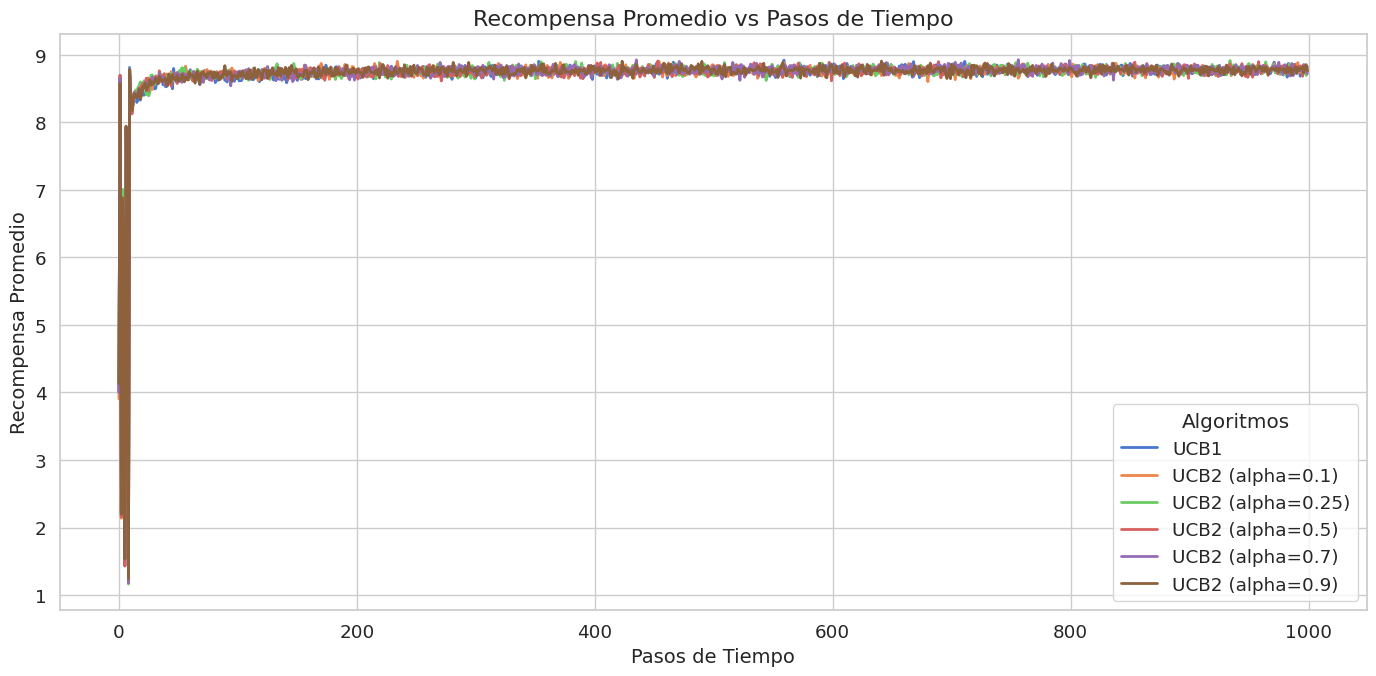

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  *  Todas las variantes de UCB2 (α = 0.1, 0.25, 0.5, 0.7, 0.9) y UCB1 convergen rápidamente a una recompensa promedio cercana a 9.
  * En las primeras iteraciones hay una fase de exploración en la que la recompensa fluctúa, pero después se estabiliza. Esta fase de exploración es un poco más larga e irregular que la de la distribución normal.
  
**Conclusiones**
  * UCB1 y todas las variantes de UCB2 tienen un desempeño similar, logrando rápidamente una recompensa óptima.
  * El aprendizaje es rápido, con las curvas estabilizándose en muy pocos pasos de tiempo.

##### Regret acumulado

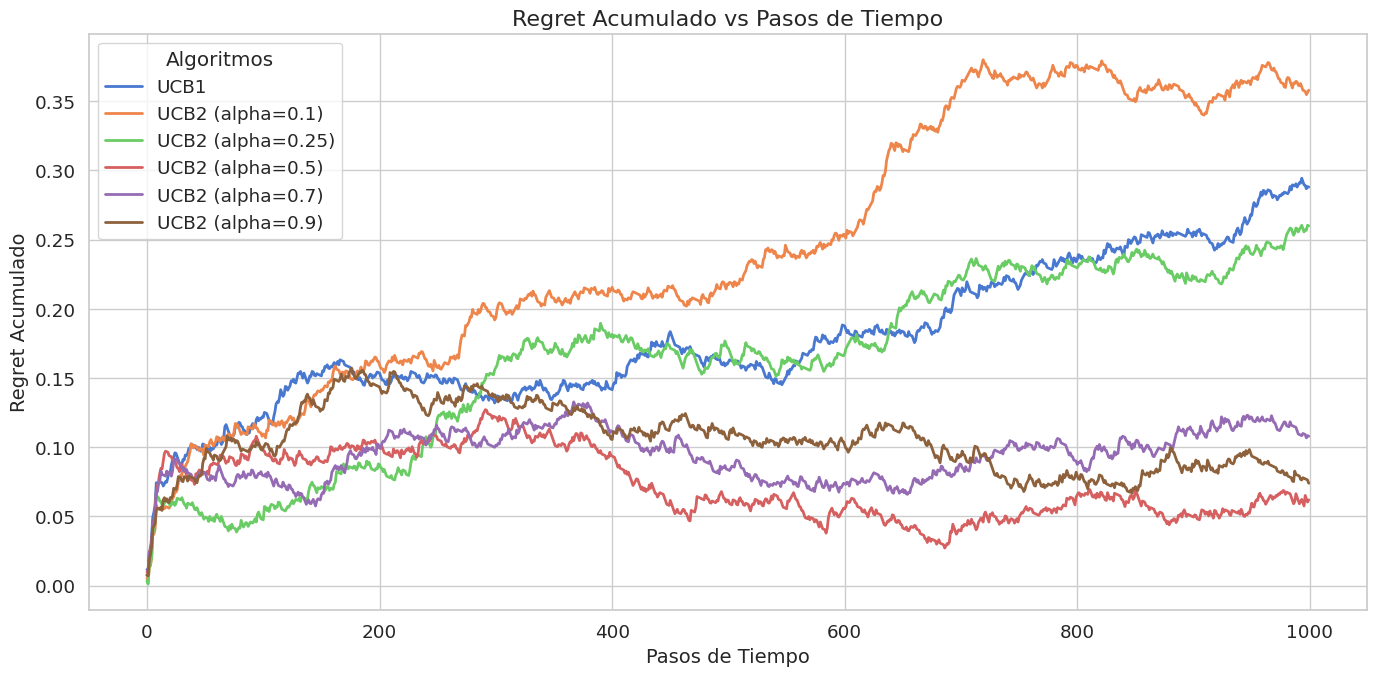

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", que evalúa el desempeño de diferentes algoritmos en términos de la pérdida acumulada al no elegir siempre la mejor acción.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  * Todas las variantes de UCB muestran un crecimiento inicial rápido en el regret acumulado durante los primeros pasos de tiempo. Esto se debe a la fase de exploración.
  * Se observa que las variantes de UCB2 con alpha bajo (0.1, 0.25) tienen un regret acumulado similar y más alto en comparación con las variantes de UCB2 con alpha más alto (0.5, 0.7 y 0.9). Esto sugiere que las variantes con alpha alto logran converger al brazo óptimo más rápido y con mayor precisión en el contexto binomial.

**Conclusiones**
  * El aprendizaje es rápido y eficiente, ya que el regret acumulado es bajo en todos los casos.
  * En este caso si que hay diferencias significativas entre las variantes de UCB2 que justifiquen una preferencia clara por un valor de α sobre otro. Principalmente, alphas altos.

##### Porcentaje de selección del brazo óptimo

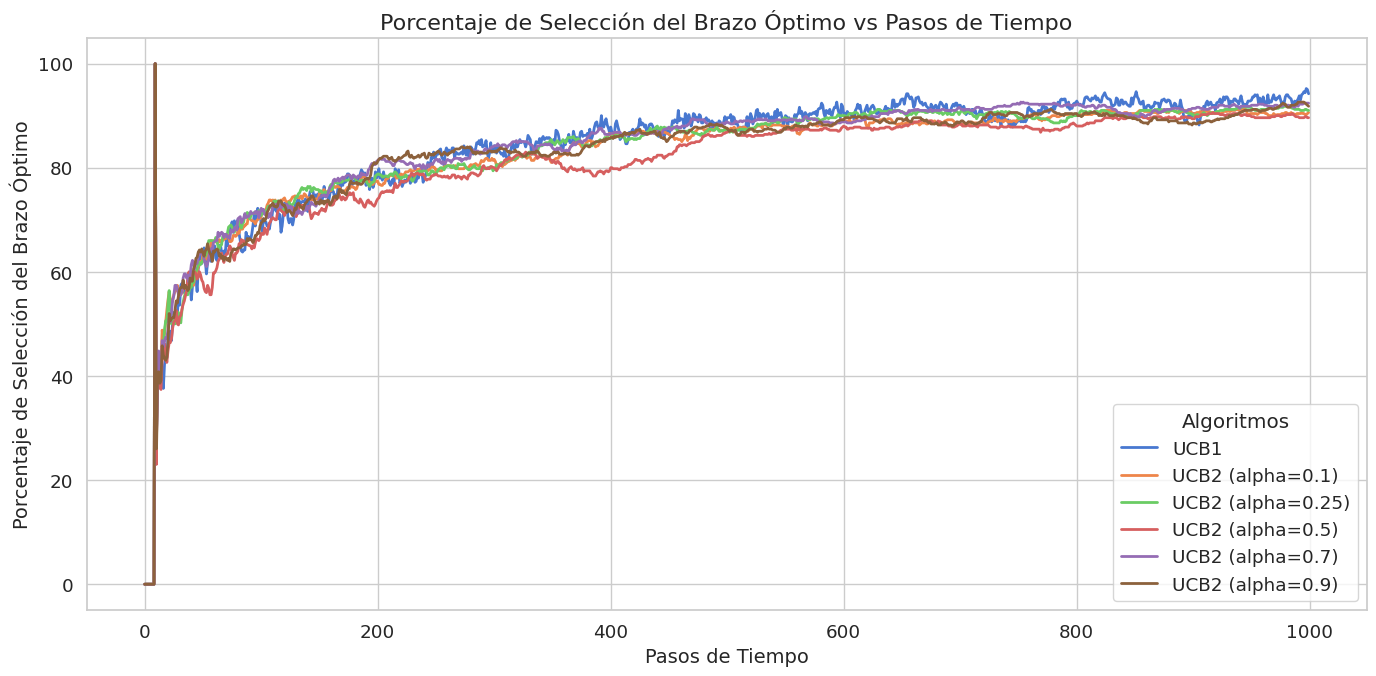

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Observaciones principales**
  * Todas las variantes de UCB2 (α = 0.1, 0.25, 0.5, 0.7, 0.9) y UCB1 convergen rápidamente a una porcentaje de selección del brazo óptimo del 90%.
  * En las primeras iteraciones hay una fase de exploración en la que la recompensa fluctúa, pero después se estabiliza.
  * Aquí podemos observar una gráfica más parecida a la que encontramos cuando aumentamos los brazos.

**Conclusiones**

  * Distribución binomial muestra los mismos resultados que con 15, 20 y 30 brazos.
  

#### Conclusión
El comportamiento de los algoritmos UCB1 y UCB2 en un contexto de 10 brazos y con una distribución binomial revela una serie de características interesantes que se diferencian de las observadas con una distribución normal.

En el caso de la distribución binomial, cada brazo tiene un número limitado de éxitos (por ejemplo, puede representar la probabilidad de obtener una victoria en un número determinado de intentos) y la recompensa de cada brazo es un valor binario (éxito o fracaso), lo que hace que las recompensas sean más discretas que en el caso de una distribución normal. Esto afecta la forma en que los algoritmos UCB1 y UCB2 exploran y explotan los brazos:
1. Exploración y Convergencia:
  * La fase de exploración en la distribución binomial es algo más larga e irregular que en una distribución normal.
  * A pesar de que las variantes de UCB1 y UCB2 logran rápidamente una recompensa promedio cercana a la óptima, la exploración adicional es más notable al principio.
2. Regret Acumulado:
  * Al principio, todos los algoritmos muestran un aumento rápido en el regret acumulado debido a la fase de exploración.
3. Selección del Brazo Óptimo:
  * En cuanto al porcentaje de selección del brazo óptimo, todas las variantes de UCB2 y UCB1 muestran una alta tasa de selección del brazo óptimo, alcanzando rápidamente un porcentaje cercano al 90%. Sin embargo, al principio del proceso, la tasa de selección del brazo óptimo puede fluctuar, lo que refleja el proceso de exploración.

#### Distribución de Bernoulli

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 5 algoritmos softmax con diferentes valores de tau.
algorithms = [UCB1(k=k), UCB2(k=k, alpha=0.1), UCB2(k=k, alpha=0.25), UCB2(k=k, alpha=0.5), UCB2(k=k, alpha=0.7), UCB2(k=k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regrets, arm_counts, arm_rewards = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.4), ArmBernoulli(p=0.86), ArmBernoulli(p=0.22), ArmBernoulli(p=0.69), ArmBernoulli(p=0.58), ArmBernoulli(p=0.15), ArmBernoulli(p=0.79), ArmBernoulli(p=0.67), ArmBernoulli(p=0.12), ArmBernoulli(p=0.88)
Optimal arm: 10 with expected reward=0.88


##### Recompensa promedio

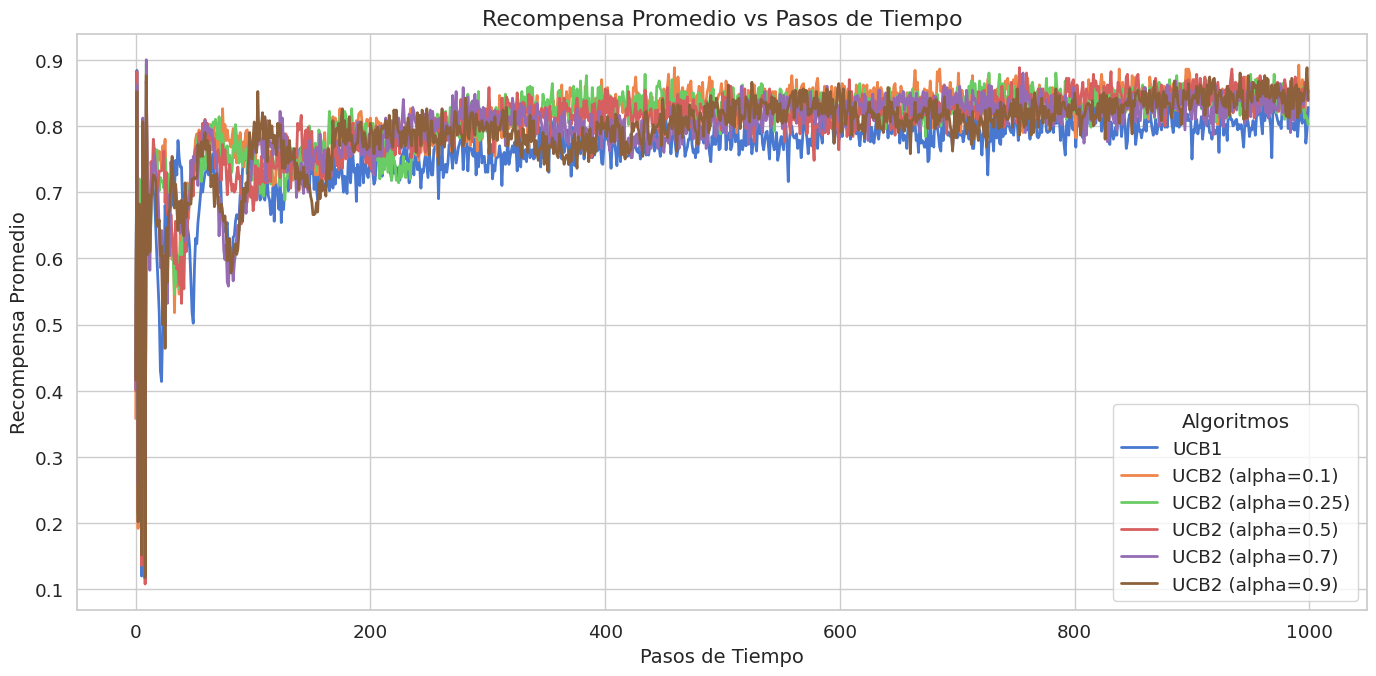

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

La imagen muestra un gráfico de líneas titulado "Recompensa Promedio vs Pasos de Tiempo", que evalúa el rendimiento de distintos algoritmos.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  *  Todas las variantes de UCB muestran una fluctuación significativa en la recompensa promedio.
  * Todas las variantes de UCB muestran un rendimiento similar, pero podemos observar que las variantes de UCB2 con alpha alto son las que obtienen los peores resultados. Al inicio se puede ver que tardan unas iteraciones más en converger hacia la recompensa promedio. Lo mismo le pasa a UCB1.
  
**Conclusiones**
  * Aquí si que podemos decir que las variantes de UCB2 con alphas bajos son superiores.
  * El aprendizaje es rápido, con las curvas estabilizándose en muy pocos pasos de tiempo.

##### Regret acumulado

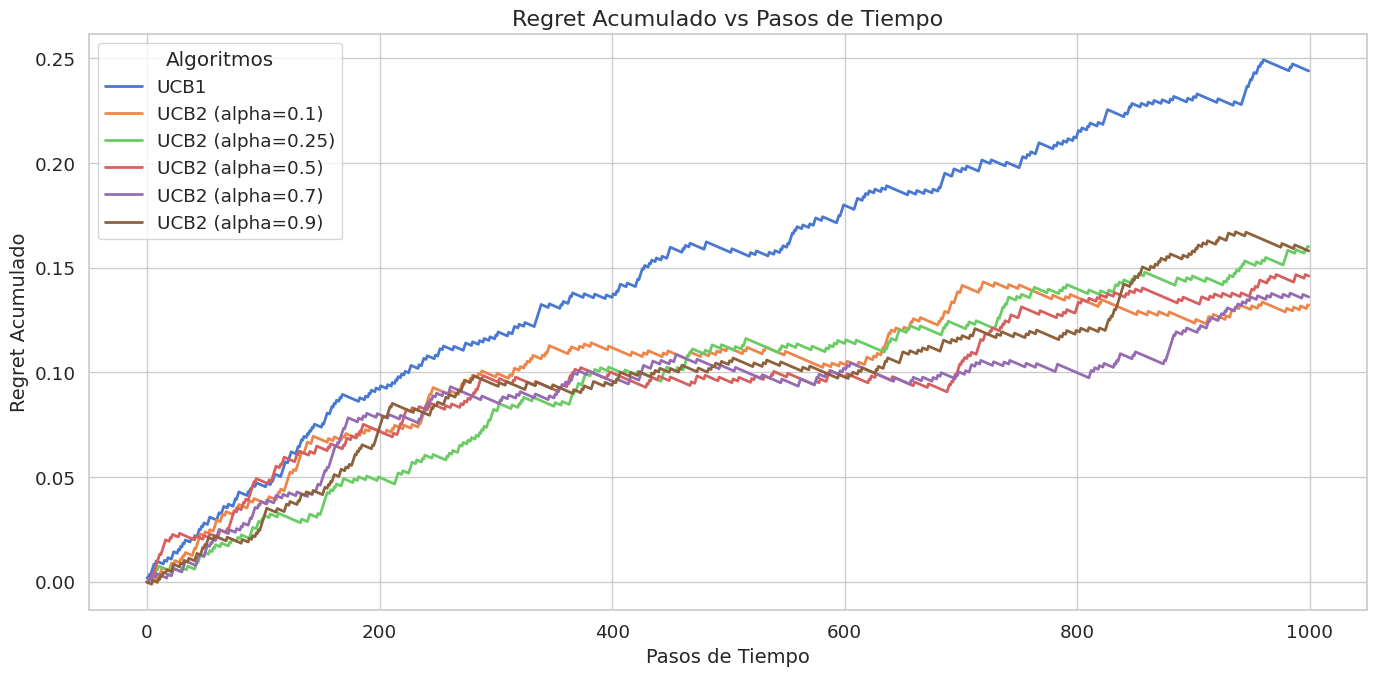

In [ ]:
plot_regret(steps, regrets, algorithms)

La imagen muestra un gráfico de líneas titulado "Regret Acumulado vs Pasos de Tiempo", que evalúa el desempeño de diferentes algoritmos en términos de la pérdida acumulada al no elegir siempre la mejor acción.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**: "Recompensa Promedio" → Muestra la recompensa acumulada a lo largo del tiempo.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Análisis del comportamiento**
  * Se observa que las variantes de UCB2 tienen un regret acumulado similar y más bajo en comparación con UCB1.

**Conclusiones**
  * El aprendizaje es rápido y eficiente, ya que el regret acumulado es bajo en todos los casos.
  * En este caso si que hay diferencias significativas entre UCB1 y UCB2.

##### Porcentaje de selección del brazo óptimo

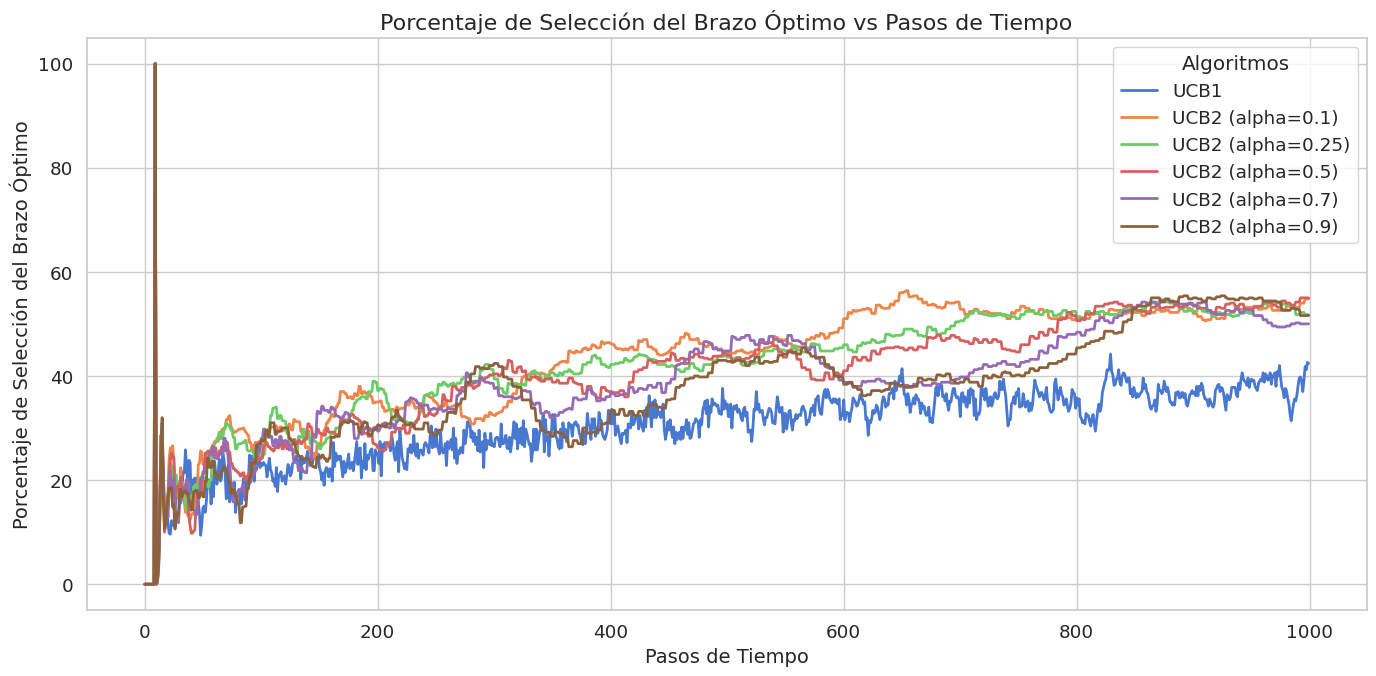

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

La imagen muestra un gráfico de líneas titulado "Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo", donde se compara el desempeño de diferentes variantes del algoritmo UCB.

**Interpretación**
  * Se observa que las variantes de UCB2 con alpha bajo (0.1, 0.25 y 0.5) alcanzan un porcentaje de selección del brazo óptimo similar y más alto en comparación con las variantes de UCB2 con alpha más alto (0.7 y 0.9).
  * También podemos observar que UCB1, por momentos, es el que tiene el porcentaje de selección más alto. Esto lo podemos correlacionar con los momentos en los que en la gráfica anterior se ve un descenso del regret acumulado.

  Este gráfico muestra el **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**, lo que indica qué tan frecuentemente cada algoritmo selecciona la mejor opción a medida que avanza el tiempo.

**Elementos clave del gráfico**
* **Eje X (horizontal)**: "Pasos de Tiempo" → Representa la cantidad de iteraciones o decisiones tomadas.
* **Eje Y (vertical)**:  "Porcentaje de Selección del Brazo Óptimo" → Indica la frecuencia con la que el algoritmo escoge la mejor opción disponible.
* **Líneas de diferentes colores**: Representan distintos algoritmos: UCB1 y variantes de UCB2 con distintos valores del parámetro α.

**Observaciones principales**
  * Todas las variantes de UCB2 convergen rápidamente a una porcentaje de selección del brazo óptimo del 50%.
  * En las primeras iteraciones hay una fase de exploración en la que la recompensa fluctúa, pero después se estabiliza.

**Conclusiones**

  * Solo un 50% de las veces selecciónan el brazo óptimo.
  

#### Conclusión

Los algoritmos UCB1 y UCB2 muestran un rendimiento eficiente en términos de exploración y explotación, pero con algunas variaciones importantes respecto a su comportamiento en una distribución normal. La naturaleza de la distribución de Bernoulli, donde las recompensas de cada brazo son binarias (éxito o fracaso), tiene un impacto significativo en la convergencia de los algoritmos y en la selección del brazo óptimo.

Las variantes de UCB2 con valores bajos de α (como 0.1, 0.25 y 0.5) explotan los brazos más rápidamente, ya que estos valores favorecen la explotación temprana del conocimiento obtenido sobre los brazos. Al hacerlo, estas variantes minimizan el regret acumulado y logran una recompensa promedio más alta de manera más eficiente.

La discreción de las recompensas hace que los algoritmos necesiten explorar de manera más específica para discernir rápidamente cuál es el brazo óptimo. Las recompensas binarias no proporcionan la misma información precisa sobre la calidad del brazo que una distribución continua como la normal. Por lo tanto, la fase de exploración puede ser más pronunciada y durar más tiempo que en el caso de distribuciones continuas, donde los algoritmos pueden aprender de las recompensas en una escala más fluida.

# Conclusiones finales

A lo largo del experimento, probamos el algoritmo UCB1 y UCB2 con diferentes configuraciones de número de brazos y distribuciones de recompensa. A partir de los resultados obtenidos, podemos extraer varias conclusiones clave sobre cómo estas variables afectan el rendimiento del algoritmo.

1. **Impacto del Número de Brazos**

  El incremento en el número de brazos (de 10 a 20 y 30) genera un aumento en la fase de exploración, lo que ralentiza la convergencia hacia el brazo óptimo debido a la necesidad de explorar más opciones antes de encontrar la mejor.

2. **Impacto de la distribución de Recompensas**

  La distribución de recompensas afecta cómo el algoritmo aprende y selecciona el mejor brazo.
  
  **Distribución Normal**

  La distribución normal tiene un impacto positivo en la convergencia de los algoritmos, ya que sus recompensas son más predecibles y menos ruidosas en comparación con distribuciones discretas como binomial o Bernoulli. Este entorno más estable permite que los algoritmos realicen estimaciones más precisas de las recompensas esperadas, acelerando el proceso de aprendizaje y mejorando la eficiencia del UCB.

  **Distribucion Binomial**

  En el contexto de una distribución binomial, donde las recompensas son discretas (éxito o fracaso), los algoritmos UCB1 y UCB2 experimentan una fase de exploración más larga e irregular en comparación con la distribución normal. Sin embargo, a pesar de esta fase prolongada, los algoritmos logran una rápida convergencia hacia la recompensa óptima, alcanzando un rendimiento eficiente con un porcentaje cercano al 90% en la selección del brazo óptimo.

  **Distribución Bernoulli**

  La distribución Bernoulli, que también se caracteriza por recompensas binarias, presenta desafíos adicionales para los algoritmos, ya que las recompensas no proporcionan información tan fluida sobre la calidad del brazo como en las distribuciones continuas. Esto lleva a una fase de exploración más pronunciada y prolongada.

**¿Por qué hay esas variaciones al inicio de UCB2?**

Al principio del algoritmo, UCB2 asume que no sabe nada sobre las recompensas de los brazos, por lo que asigna un valor optimista a la recompensa de cada brazo. Esto significa que, para cada brazo, el algoritmo considera no solo la recompensa promedio observada hasta el momento, sino también un "margen de confianza" que puede hacer que inicialmente sobreestime las recompensas de brazos menos explorados.

Este margen de confianza inicial puede llevar a una exploración más agresiva de brazos que aún no se han probado lo suficiente. Como resultado, UCB2 puede seleccionar más brazos de lo necesario en las primeras iteraciones, lo que genera una fluctuación en las recompensas.